# Exploration and plot generation
This notebook generates many plots based on spells_15_days and spells_21_days.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import chain
from collections import Counter
import re
import numpy as np

base = Path("/n/scratch/users/b/bef299/polypharmacy_project/")


# --- Load data ---
spells_15_days = pd.read_parquet(base / "spells_with_labels_15_days.parquet")
rx_fills = pd.read_parquet(base / "rx_fills.parquet")
demographics = pd.read_parquet(base / "demographics.parquet")

spells_21_days = pd.read_parquet(base / "spells_with_labels_21_days.parquet")

In [3]:
# --- 🧮 Spell summary comparison (15 vs 21 day extensions) ---

def summarize_spells(label, df):
    """Get spell summary statistics."""
    total = len(df)
    one_per = len(df.drop_duplicates(subset=["MemberUID"], keep="first"))
    return total, one_per, one_per / total * 100

# Summaries
total_15, one_15, pct_15 = summarize_spells("15-day", spells_15_days)
total_21, one_21, pct_21 = summarize_spells("21-day", spells_21_days)

print("📊 Spell Summary Comparison")
print("-" * 60)
print(f"{'Config':<20}{'Total Spells':>15}{'1/Patient':>15}{'% of Total':>10}")
print("-" * 60)
print(f"{'15-day extension':<20}{total_15:>15,}{one_15:>15,}{pct_15:>9.2f}%")
print(f"{'21-day extension':<20}{total_21:>15,}{one_21:>15,}{pct_21:>9.2f}%")
print("-" * 60)


📊 Spell Summary Comparison
------------------------------------------------------------
Config                 Total Spells      1/Patient% of Total
------------------------------------------------------------
15-day extension             11,212          6,936    61.86%
21-day extension             10,828          7,110    65.66%
------------------------------------------------------------


In [4]:
spells = spells_21_days.copy()

# --- Initial AE counts ---
n_total_spells = len(spells)
n_with_ae_before = spells["had_ae"].sum()
pct_with_ae_before = n_with_ae_before / n_total_spells * 100

print("📊 Adverse Event Summary (Before Exclusion List)")
print("-" * 70)
print(f"Total spells: {n_total_spells:,}")
print(f"Spells with any AE: {n_with_ae_before:,} ({pct_with_ae_before:.2f}%)")
print("-" * 70)

# --- Load ICD-10 codes to remove ---
to_remove = pd.read_csv("to_remove_icd10_codes.csv")  # columns: code, description
patterns_to_remove = to_remove["code"].dropna().astype(str).tolist()

# --- Helper: remove AE codes and count matches per exclusion pattern ---
removed_counts = {pat: 0 for pat in patterns_to_remove}

def remove_excluded_codes(ae_array):
    """Remove AE codes that match any exclusion pattern, tracking removal counts."""
    if not isinstance(ae_array, (list, np.ndarray)):
        return np.array([], dtype=object)
    filtered = []
    for code in ae_array:
        code_str = str(code)
        matched_pattern = None
        for pattern in patterns_to_remove:
            if "%" in pattern:
                if code_str.startswith(pattern.replace("%", "")):
                    matched_pattern = pattern
                    break
            elif code_str == pattern:
                matched_pattern = pattern
                break
        if matched_pattern:
            removed_counts[matched_pattern] += 1
        else:
            filtered.append(code_str)
    return np.array(filtered, dtype=object)

# --- Focus on AE spells and apply exclusions ---
ae_spells = spells[spells["had_ae"]].copy()
ae_spells["ae_codes"] = ae_spells["ae_codes"].apply(remove_excluded_codes)

# Update had_ae flag (True if AE array still has any elements)
ae_spells["had_ae"] = ae_spells["ae_codes"].apply(
    lambda x: isinstance(x, np.ndarray) and x.size > 0
)

# --- Compute post-filter stats ---
n_with_ae_after = ae_spells["had_ae"].sum()
pct_with_ae_after = n_with_ae_after / n_total_spells * 100
ae_removed = n_with_ae_before - n_with_ae_after
pct_removed = ae_removed / n_with_ae_before * 100 if n_with_ae_before > 0 else 0

# --- Summary output ---
print("\n🧹 Adverse Event Summary (After Applying Exclusion List)")
print("-" * 70)
print(f"Spells with AE remaining: {n_with_ae_after:,} ({pct_with_ae_after:.2f}%)")
print(f"AEs removed (by exclusion list): {ae_removed:,} ({pct_removed:.2f}% of AEs removed)")
print("-" * 70)

# --- Count how many AEs were removed by each exclusion pattern ---
removed_summary = (
    pd.DataFrame([
        {"code": pat, "description": to_remove.loc[to_remove["code"] == pat, "description"].values[0], "removed_count": cnt}
        for pat, cnt in removed_counts.items()
    ])
    .sort_values("removed_count", ascending=False)
    .reset_index(drop=True)
)

print("\n📊 AEs Removed by Exclusion Pattern:")
print(removed_summary.to_string(index=False))

📊 Adverse Event Summary (Before Exclusion List)
----------------------------------------------------------------------
Total spells: 10,828
Spells with any AE: 520 (4.80%)
----------------------------------------------------------------------

🧹 Adverse Event Summary (After Applying Exclusion List)
----------------------------------------------------------------------
Spells with AE remaining: 163 (1.51%)
AEs removed (by exclusion list): 357 (68.65% of AEs removed)
----------------------------------------------------------------------

📊 AEs Removed by Exclusion Pattern:
code                                                                description  removed_count
F32%                                                             Mood disorders            206
R42%                                                    Dizziness and giddiness            165
R410                                                 Disorientation unspecified             50
R296                                      


📋 Top Adverse Event Codes and Descriptions
--------------------------------------------------------------------------------
CodeValue  Count                                                                                         Description  % of Total
    F1120     19                                              Mental and behavioural disorders due to use of opioids       17.92
    F1320     12                               Mental and behavioural disorders due to use of sedatives or hypnotics       11.32
  T45515A      9       Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances        8.49
  T887XXA      8                                                                Unspecified adverse effect of a drug        7.55
  T451X5A      8       Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances        7.55
  T7840XA      8                                                            Adverse effects not elsew

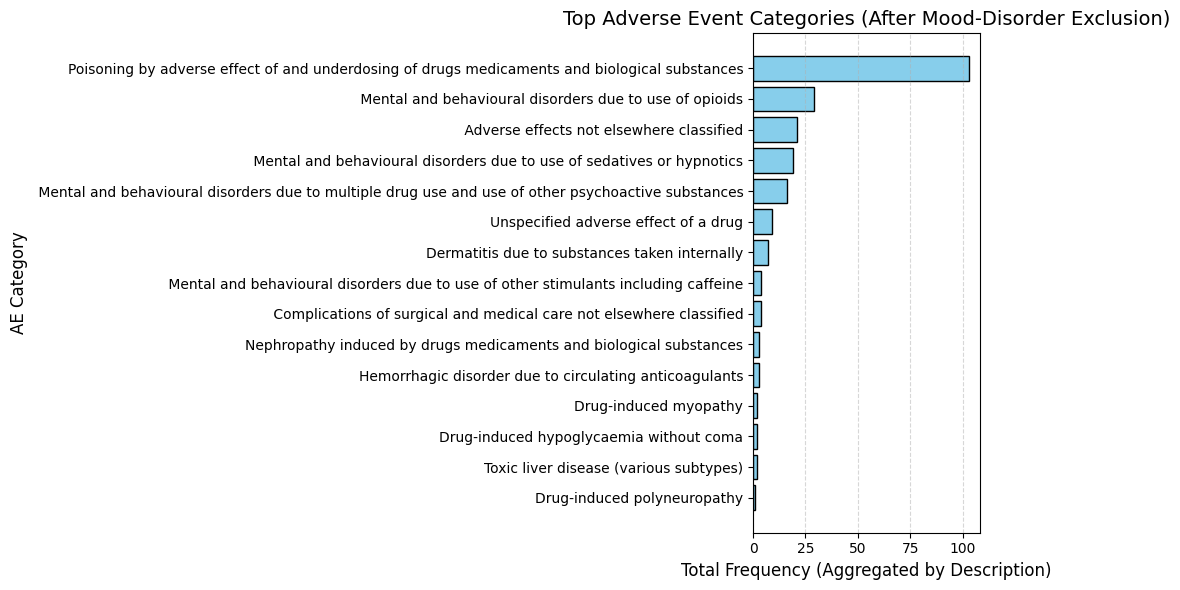


🧮 Aggregated AE Category Counts (for plot)
                                                                                        Description  Count
      Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances    103
                                             Mental and behavioural disorders due to use of opioids     29
                                                           Adverse effects not elsewhere classified     21
                              Mental and behavioural disorders due to use of sedatives or hypnotics     19
 Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances     16
                                                               Unspecified adverse effect of a drug      9
                                                      Dermatitis due to substances taken internally      7
                 Mental and behavioural disorders due to use of other stimulants including caffeine 

In [5]:
# --- ⚙️ Flatten AE codes across all AE spells ---
all_ae_codes = list(chain.from_iterable(ae_spells["ae_codes"]))
ae_freq = Counter(all_ae_codes)
ae_freq_df = (
    pd.DataFrame(ae_freq.items(), columns=["CodeValue", "Count"])
    .sort_values("Count", ascending=False)
    .reset_index(drop=True)
)

# --- 📖 Read mapping CSV (with lazy SQL-like patterns) ---
ae_map = pd.read_csv("icd10_codes.csv")

def map_description(code):
    """Return AE description using SQL-like % wildcards."""
    for _, row in ae_map.iterrows():
        pattern = row["code"].replace("%", "")
        if str(code).startswith(pattern):
            return row["description"]
    return "Unknown AE code"

ae_freq_df["Description"] = ae_freq_df["CodeValue"].apply(map_description)

# --- 📊 Summary Table of Top AE Codes ---
top_n = 15
top_ae_df = ae_freq_df.head(top_n).copy()
top_ae_df["% of Total"] = (top_ae_df["Count"] / top_ae_df["Count"].sum() * 100).round(2)

print("\n📋 Top Adverse Event Codes and Descriptions")
print("-" * 80)
print(top_ae_df.to_string(index=False))
print("-" * 80)
print(f"Showing top {top_n} AE categories out of {len(ae_freq_df):,} total unique codes.\n")

# --- 🔢 Aggregate by Description for visualization ---
agg_by_desc = (
    ae_freq_df.groupby("Description", as_index=False)["Count"]
    .sum()
    .sort_values("Count", ascending=False)
)

# Take top N descriptions for plotting
top_desc = agg_by_desc.head(top_n)

# --- 🎨 Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(top_desc["Description"], top_desc["Count"], color="skyblue", edgecolor="black")
plt.gca().invert_yaxis()  # Highest on top
plt.title("Top Adverse Event Categories (After Mood-Disorder Exclusion)", fontsize=14)
plt.xlabel("Total Frequency (Aggregated by Description)", fontsize=12)
plt.ylabel("AE Category", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- 🧮 Print small summary of aggregation ---
print("\n🧮 Aggregated AE Category Counts (for plot)")
print(top_desc.to_string(index=False))


📊 Spell Length Statistics (Days)
------------------------------------------------------------
       AE Spells  Non-AE Spells
count     520.00       10308.00
mean      241.74         145.14
std       135.75         110.25
min        51.00          51.00
25%       119.75          68.00
50%       209.50         102.00
75%       390.00         177.00
max       476.00        1141.00
------------------------------------------------------------
AE spells: 520 | Non-AE spells: 10,308


/tmp/ipykernel_3507802/1747380832.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


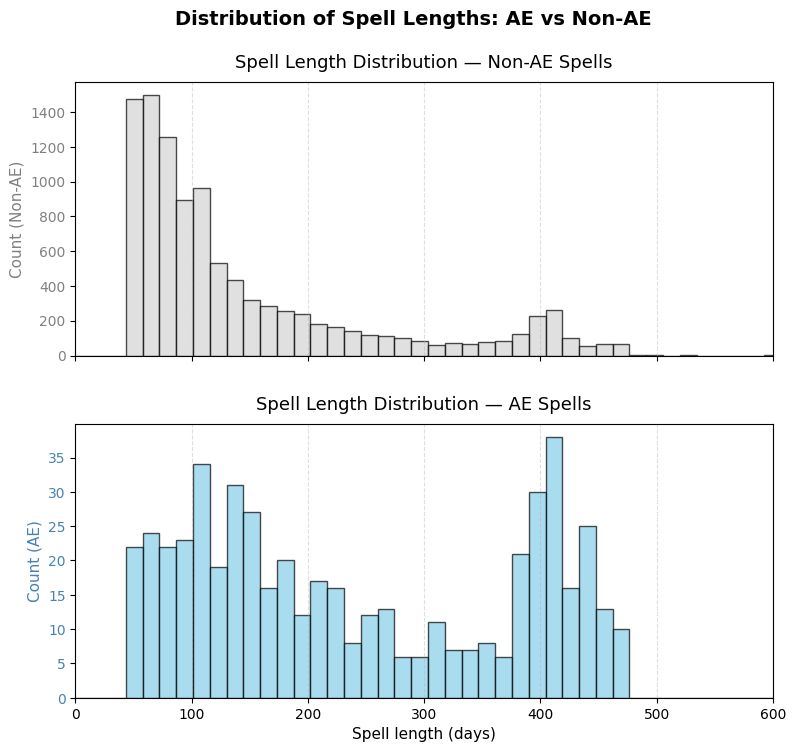

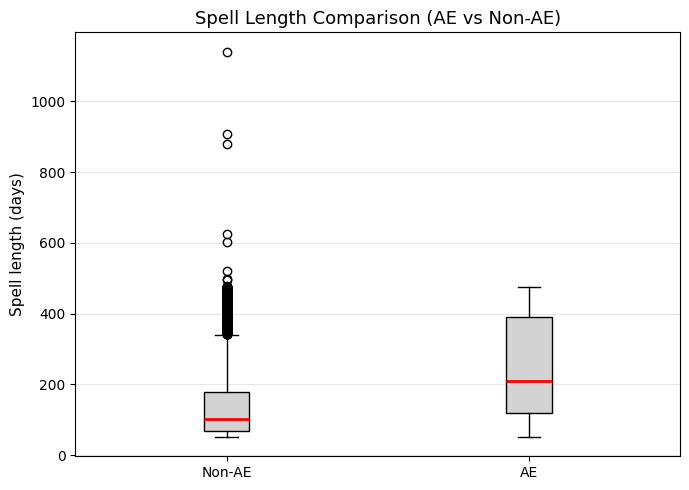

In [6]:
# --- 🧮 Split AE vs non-AE spells ---
ae_group = spells_21_days[spells_21_days["had_ae"]].copy()
non_ae_group = spells_21_days[~spells_21_days["had_ae"]].copy()

# --- 📈 Descriptive statistics ---
ae_stats = ae_group["spell_length_days"].describe()
non_ae_stats = non_ae_group["spell_length_days"].describe()

# Combine into comparison table
comparison_df = pd.DataFrame({
    "AE Spells": ae_stats.round(2),
    "Non-AE Spells": non_ae_stats.round(2)
})
print("\n📊 Spell Length Statistics (Days)")
print("-" * 60)
print(comparison_df)
print("-" * 60)
print(f"AE spells: {len(ae_group):,} | Non-AE spells: {len(non_ae_group):,}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={"hspace": 0.25})
bins = np.linspace(0, max(spells_21_days["spell_length_days"]), 80)

# --- Top plot: Non-AE group ---
ax1.hist(
    non_ae_group["spell_length_days"],
    bins=bins, color="lightgray", edgecolor="black", alpha=0.7
)
ax1.set_title("Spell Length Distribution — Non-AE Spells", fontsize=13, pad=10)
ax1.set_ylabel("Count (Non-AE)", color="gray", fontsize=11)
ax1.tick_params(axis="y", labelcolor="gray")
ax1.grid(axis="x", linestyle="--", alpha=0.4)

# --- Bottom plot: AE group ---
ax2.hist(
    ae_group["spell_length_days"],
    bins=bins, color="skyblue", edgecolor="black", alpha=0.7
)
ax2.set_title("Spell Length Distribution — AE Spells", fontsize=13, pad=10)
ax2.set_xlabel("Spell length (days)", fontsize=11)
ax2.set_ylabel("Count (AE)", color="steelblue", fontsize=11)
ax2.tick_params(axis="y", labelcolor="steelblue")
ax2.grid(axis="x", linestyle="--", alpha=0.4)

# --- Shared layout adjustments ---
plt.xlim(0, 600)
plt.suptitle("Distribution of Spell Lengths: AE vs Non-AE", fontsize=14, fontweight="bold", y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 🎨 Boxplot comparison ---
plt.figure(figsize=(7, 5))
plt.boxplot(
    [non_ae_group["spell_length_days"].dropna(), ae_group["spell_length_days"].dropna()],
    tick_labels=["Non-AE", "AE"],
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red", linewidth=2)
)
plt.title("Spell Length Comparison (AE vs Non-AE)", fontsize=13)
plt.ylabel("Spell length (days)", fontsize=11)
plt.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.show()


In [8]:
# --- 💊 Drug Utilization Overview (AE Patients) ---

# 1️⃣ Identify AE patients
ae_members = ae_spells["MemberUID"].unique()

# 2️⃣ Filter RX fills for these members
rx_fills_ae = rx_fills[rx_fills["MemberUID"].isin(ae_members)]

# 3️⃣ Summary counts
n_patients = rx_fills_ae["MemberUID"].nunique()
n_fills = len(rx_fills_ae)

print(f"\n📊 RX Summary for AE Patients")
print("-" * 60)
print(f"Unique AE patients with fills: {n_patients:,}")
print(f"Total RX fills among AE patients: {n_fills:,}")

# 4️⃣ Compute most common drugs (by NDC code)
drug_counts = (
    rx_fills_ae["ndc11code"]
    .value_counts()
    .rename_axis("ndc11code")
    .reset_index(name="count")
)

print("\n💊 Top 10 Most Common Drugs (by NDC11 Code):")
print(drug_counts.head(10).to_string(index=False))




📊 RX Summary for AE Patients
------------------------------------------------------------
Unique AE patients with fills: 499
Total RX fills among AE patients: 50,739

💊 Top 10 Most Common Drugs (by NDC11 Code):
  ndc11code  count
00003089421    238
00173068220    228
00781279010    216
60505258009    178
57237001405    173
00173069600    169
60505025302    162
00088221905    150
60505257909    149
59310057922    148


In [9]:
import pandas as pd

# --- 👥 Demographics Comparison: AE vs Non-AE ---

# Define AE and Non-AE members
ae_members = ae_spells["MemberUID"].unique()
non_ae_members = spells_21_days.loc[~spells_21_days["MemberUID"].isin(ae_members), "MemberUID"].unique()

ae_demo = demographics[demographics["MemberUID"].isin(ae_members)].copy()
non_ae_demo = demographics[demographics["MemberUID"].isin(non_ae_members)].copy()

print(f"\n📊 Demographics Summary")
print("-" * 60)
print(f"AE patients: {len(ae_demo):,}")
print(f"Non-AE patients: {len(non_ae_demo):,}")
print("-" * 60)

# --- Gender distribution ---
gender_ae = ae_demo["gendercode"].value_counts(normalize=True).rename("AE (%)") * 100
gender_non = non_ae_demo["gendercode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
gender_table = pd.concat([gender_ae, gender_non], axis=1).fillna(0).round(2)

# --- Race / Ethnicity distribution ---
race_ae = ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("AE (%)") * 100
race_non = non_ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
race_table = pd.concat([race_ae, race_non], axis=1).fillna(0).round(2)

# --- State distribution (Top 10 AE states) ---
state_ae = ae_demo["statecode"].value_counts(normalize=True).rename("AE (%)") * 100
state_non = non_ae_demo["statecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
# Restrict to top 10 AE states for clarity
top_states = state_ae.head(10).index
state_table = pd.concat([state_ae.loc[top_states], state_non.loc[top_states]], axis=1).fillna(0).round(2)

# --- Display results ---
print("\n🧍 Gender Distribution (% of group):")
print(gender_table.to_string())

print("\n🌎 Race / Ethnicity Distribution (% of group):")
print(race_table.to_string())

print("\n📍 Top 10 States (by AE frequency, % of group):")
print(state_table.to_string())



📊 Demographics Summary
------------------------------------------------------------
AE patients: 589
Non-AE patients: 7,342
------------------------------------------------------------

🧍 Gender Distribution (% of group):
            AE (%)  Non-AE (%)
gendercode                    
F            57.05       56.88
M            42.95       43.12

🌎 Race / Ethnicity Distribution (% of group):
                       AE (%)  Non-AE (%)
raceethnicitytypecode                    
09                      41.77       49.09
01                      39.56       31.08
11                       6.62        6.02
02                       5.94        6.44
06                       4.58        4.07
04                       1.53        3.30

📍 Top 10 States (by AE frequency, % of group):
           AE (%)  Non-AE (%)
statecode                    
CA          17.55       13.09
NY          17.21       15.89
TX           7.50        7.47
FL           7.50        7.43
IL           7.50        3.74
MI          

📊 Summary of Gaps Between Spells (raw_exit → next entry)
-----------------------------------------------------------------
Version   |   Mean   Median   Std   Min   Max   Count
-----------------------------------------------------------------
15 days   |  61.86    39.00   54.02    16     352    4,276
21 days   |  68.63    47.00   54.70    22     329    3,718
-----------------------------------------------------------------


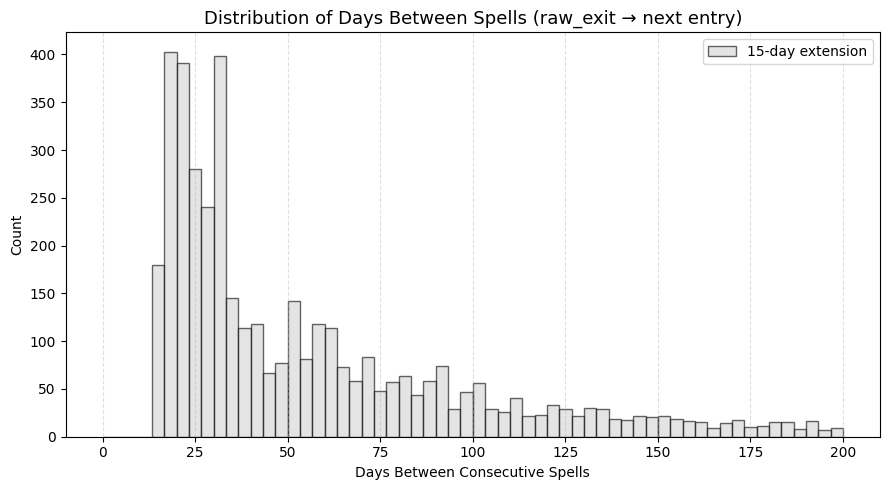

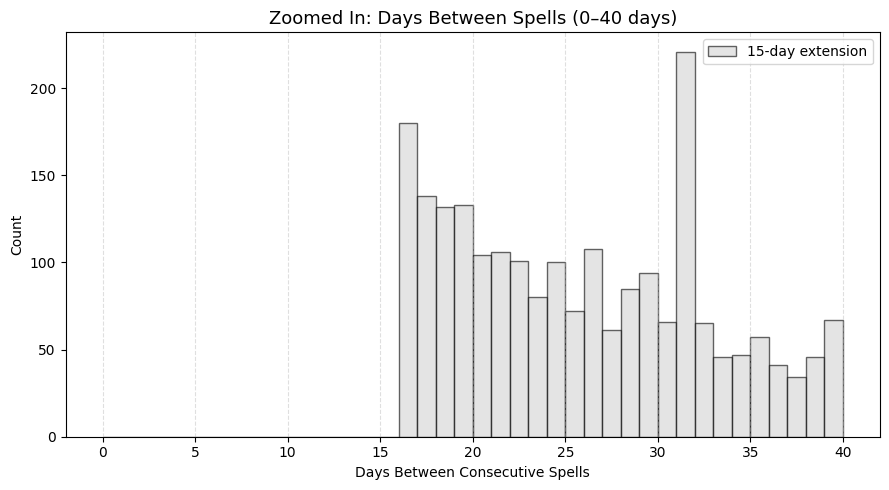

In [10]:
# --- 3️⃣ Compare Gap Between Spells (15-day vs 21-day extensions) ---

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def compute_gaps(spells_df):
    """Compute gap in days between consecutive spells for each patient."""
    # Ensure datetime types
    date_cols = ["entry_date", "raw_exit_date", "extended_exit_date", "followup_end_date"]
    for col in date_cols:
        if not np.issubdtype(spells_df[col].dtype, np.datetime64):
            spells_df[col] = pd.to_datetime(spells_df[col])
    
    # Sort and compute gap between raw_exit_date of previous spell and next entry_date
    spells_sorted = spells_df.sort_values(["MemberUID", "entry_date"]).copy()
    spells_sorted["days_since_prev_raw_exit"] = (
        spells_sorted["entry_date"] - spells_sorted.groupby("MemberUID")["raw_exit_date"].shift(1)
    ).dt.days
    
    return spells_sorted["days_since_prev_raw_exit"].dropna()

# Compute gaps for both versions
gaps_15 = compute_gaps(spells_15_days)
gaps_21 = compute_gaps(spells_21_days)

# --- Summary stats ---
print("📊 Summary of Gaps Between Spells (raw_exit → next entry)")
print("-" * 65)
print("Version   |   Mean   Median   Std   Min   Max   Count")
print("-" * 65)
print(f"15 days   | {gaps_15.mean():6.2f}  {gaps_15.median():7.2f}  {gaps_15.std():6.2f}  {gaps_15.min():4.0f}  {gaps_15.max():6.0f}  {len(gaps_15):7,}")
print(f"21 days   | {gaps_21.mean():6.2f}  {gaps_21.median():7.2f}  {gaps_21.std():6.2f}  {gaps_21.min():4.0f}  {gaps_21.max():6.0f}  {len(gaps_21):7,}")
print("-" * 65)

# --- Plot full histogram (0–200 days for clarity) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps_15, bins=60, range=(0, 200), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Distribution of Days Between Spells (raw_exit → next entry)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Zoomed-in histogram (0–40 days) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps_15, bins=40, range=(0, 40), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Zoomed In: Days Between Spells (0–40 days)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
